# Classificazione Multiclasse: One-vs-All (OVA) e Regressione Logistica Multinomiale

In questo notebook esploreremo due approcci principali per estendere la regressione logistica binaria al caso della classificazione multiclasse:

1. **One-vs-All (OVA)**: Addestriamo $K$ classificatori binari, uno per ogni classe
2. **Regressione Logistica Multinomiale**: Un singolo modello che predice direttamente le probabilità per tutte le classi

## 1. Il Problema della Classificazione Multiclasse

Nella classificazione binaria, il nostro obiettivo è assegnare un'istanza a una di due possibili classi ($y \in \{0, 1\}$).

Nella classificazione multiclasse, dobbiamo assegnare un'istanza a una di $K$ possibili classi ($y \in \{0, 1, 2, ..., K-1\}$).

### Come estendere la regressione logistica al caso multiclasse?

La regressione logistica standard, che abbiamo visto in precedenza, utilizza la funzione sigmoide:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

Questa funzione trasforma un valore reale in una probabilità tra 0 e 1, ideale per la classificazione binaria.
Iniziamo a creare dati multiclasse

## 2. Creazione di un Dataset Multiclasse

Iniziamo creando un dataset sintetico con tre classi per visualizzare e testare i nostri modelli.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Impostiamo un seed per la riproducibilità
np.random.seed(42)

def create_multiclass_dataset(n_samples=1000, centers=None, std=1):
    """
    Crea un dataset sintetico multiclasse con distribuzione gaussiana
    
    Parametri:
    n_samples -- numero totale di campioni
    centers -- centri delle classi come lista di tuple (x, y)
    std -- deviazione standard delle distribuzioni
    
    Restituisce:
    X -- matrice delle feature di shape (n_samples, 2)
    y -- vettore delle etichette di shape (n_samples,)
    """
    if centers is None:
        centers = [(-5, -5), (0, 5), (5, -5)]  # Distribuzione triangolare
    
    n_classes = len(centers)
    n_samples_per_class = n_samples // n_classes
    
    X = np.zeros((n_samples, 2))
    y = np.zeros(n_samples, dtype=int)
    
    for i, (cx, cy) in enumerate(centers):
        start_idx = i * n_samples_per_class
        end_idx = (i + 1) * n_samples_per_class
        
        X[start_idx:end_idx, 0] = np.random.normal(cx, std, n_samples_per_class)
        X[start_idx:end_idx, 1] = np.random.normal(cy, std, n_samples_per_class)
        y[start_idx:end_idx] = i
    
    # Mescoliamo i dati
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

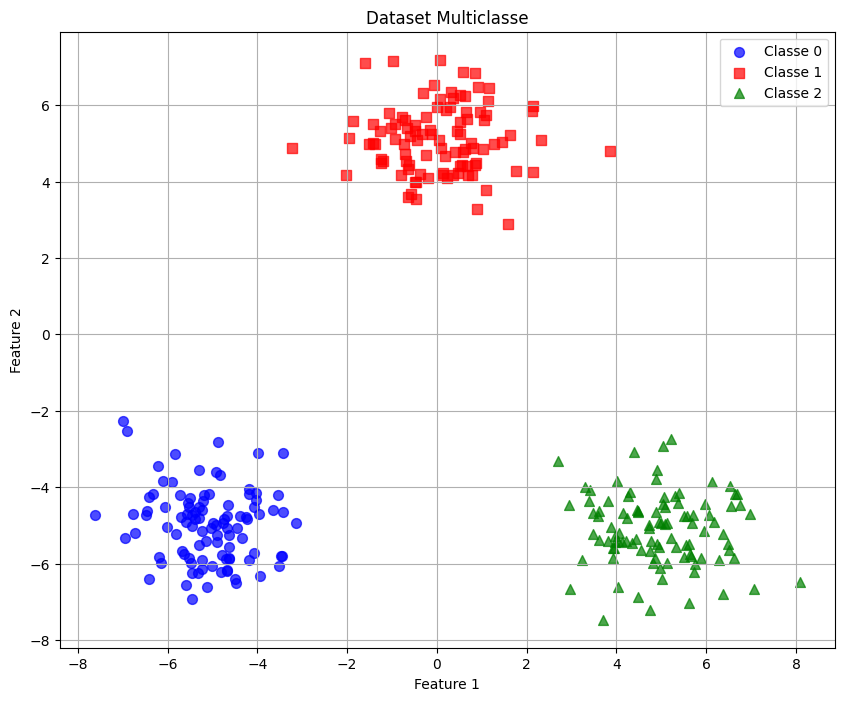

In [18]:
# Creiamo il dataset
X, y = create_multiclass_dataset(n_samples=300,std=1)

# Visualizziamo il dataset
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
markers = ['o', 's', '^']

for i in range(3):
    plt.scatter(X[y == i, 0], X[y == i, 1], 
                color=colors[i], marker=markers[i], 
                s=50, alpha=0.7, label=f'Classe {i}')

plt.title('Dataset Multiclasse')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

## 3. Implementazione One-vs-All (OVA)

L'approccio One-vs-All consiste nel:
1. Addestrare $K$ classificatori binari separati, uno per ogni classe
2. Per la classe $i$, trasformare le etichette in $\hat{y} = 1$ se $y = i$, altrimenti $\hat{y} = 0$
3. Durante la previsione, prendere la classe con la probabilità più alta

Estenderemo la classe di regressione logistica che già conosciamo:

In [19]:
class LogisticRegressionOVA:
    """
    Implementazione One-vs-All (OVA) per la regressione logistica multiclasse
    """
    
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        """
        Inizializzazione del modello
        
        Parametri:
        learning_rate: tasso di apprendimento per la discesa del gradiente
        n_iterations: numero di iterazioni per la discesa del gradiente
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.classifiers = []  # Lista di classificatori binari
        self.classes = None    # Classi uniche
    
    def fit(self, X, y):
        """
        Addestra un classificatore binario per ogni classe usando l'approccio OVA
        
        Parametri:
        X -- matrice delle feature di shape (m, n)
        y -- vettore delle etichette di shape (m,)
        """
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        
        print(f"Addestramento di {n_classes} classificatori OVA...")
        
        # Aggiungiamo una colonna di 1 per il termine di bias
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Addestriamo un classificatore per ogni classe
        for i, c in enumerate(self.classes):
            print(f"\nClassificatore per classe {c} vs resto:")
            
            # Creiamo etichette binarie: 1 per la classe corrente, 0 per tutte le altre
            y_binary = np.where(y == c, 1, 0)
            
            # Creiamo e addestriamo il classificatore
            classifier = self._train_binary_classifier(X_bias, y_binary)
            self.classifiers.append(classifier)
            
            # Calcoliamo l'accuratezza sul training set
            y_pred = self._predict_binary(X_bias, classifier) >= 0.5
            accuracy = np.mean(y_pred == y_binary)
            print(f"Accuratezza per classe {c}: {accuracy:.4f}")
        
        print("\nAddestramento OVA completato!")
    
    def _train_binary_classifier(self, X, y):
        """
        Addestra un singolo classificatore binario
        
        Parametri:
        X -- matrice delle feature con bias di shape (m, n+1)
        y -- vettore delle etichette binarie di shape (m,)
        
        Restituisce:
        weights -- pesi ottimizzati del classificatore
        """
        m, n = X.shape
        weights = np.zeros(n)
        
        for i in range(self.n_iterations):
            # Calcolo della previsione
            z = np.dot(X, weights)
            h = self._sigmoid(z)
            
            # Calcolo del gradiente
            gradient = 1/m * np.dot(X.T, (h - y))
            
            # Aggiornamento dei pesi
            weights = weights - self.learning_rate * gradient
            
            # Stampa periodica del costo
            if (i % 200 == 0) or (i == self.n_iterations - 1):
                cost = self._compute_cost(X, y, weights)
                print(f"  Iterazione {i}: Costo = {cost:.6f}")
        
        return weights
    
    def _sigmoid(self, z):
        """
        Funzione sigmoide: trasforma un numero reale in una probabilità (0-1)
        """
        # Limitiamo z per evitare overflow/underflow numerici
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _compute_cost(self, X, y, weights):
        """
        Calcola la funzione di costo (log loss)
        
        J(w) = -1/m * sum(y*log(h) + (1-y)*log(1-h))
        """
        m = X.shape[0]
        h = self._predict_binary(X, weights)
        
        # Per evitare log(0)
        epsilon = 1e-15
        h = np.clip(h, epsilon, 1 - epsilon)
        
        cost = -1/m * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
        return cost
    
    def _predict_binary(self, X, weights):
        """
        Calcola la probabilità per un classificatore binario
        """
        z = np.dot(X, weights)
        return self._sigmoid(z)
    
    def predict_proba(self, X):
        """
        Calcola le probabilità per tutte le classi
        
        Parametri:
        X -- matrice delle feature di shape (m, n)
        
        Restituisce:
        probs -- matrice di probabilità di shape (m, n_classes)
        """
        # Aggiungiamo una colonna di 1 per il termine di bias
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]
        
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        probs = np.zeros((n_samples, n_classes))
        
        # Calcoliamo le probabilità per ogni classe
        for i, classifier in enumerate(self.classifiers):
            probs[:, i] = self._predict_binary(X_bias, classifier)
        
        # Normalizziamo le probabilità per avere somma 1
        probs = probs / np.sum(probs, axis=1, keepdims=True)
        
        return probs
    
    def predict(self, X):
        """
        Predice la classe con la probabilità più alta
        
        Parametri:
        X -- matrice delle feature di shape (m, n)
        
        Restituisce:
        y_pred -- vettore delle classi predette di shape (m,)
        """
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]

In [20]:
# Addestriamo il modello OVA
ova_model = LogisticRegressionOVA(learning_rate=0.1, n_iterations=1000)
ova_model.fit(X, y)

# Valutiamo il modello
y_pred = ova_model.predict(X)
accuracy = np.mean(y_pred == y)
print(f"\nAccuratezza OVA sul training set: {accuracy:.4f}")

Addestramento di 3 classificatori OVA...

Classificatore per classe 0 vs resto:
  Iterazione 0: Costo = 0.419064
  Iterazione 200: Costo = 0.022522
  Iterazione 400: Costo = 0.014362
  Iterazione 600: Costo = 0.010997
  Iterazione 800: Costo = 0.009056
  Iterazione 999: Costo = 0.007760
Accuratezza per classe 0: 1.0000

Classificatore per classe 1 vs resto:
  Iterazione 0: Costo = 0.247864
  Iterazione 200: Costo = 0.002849
  Iterazione 400: Costo = 0.001519
  Iterazione 600: Costo = 0.001051
  Iterazione 800: Costo = 0.000810
  Iterazione 999: Costo = 0.000662
Accuratezza per classe 1: 1.0000

Classificatore per classe 2 vs resto:
  Iterazione 0: Costo = 0.418747
  Iterazione 200: Costo = 0.023721
  Iterazione 400: Costo = 0.015677
  Iterazione 600: Costo = 0.012214
  Iterazione 800: Costo = 0.010147
  Iterazione 999: Costo = 0.008730
Accuratezza per classe 2: 0.9967

Addestramento OVA completato!

Accuratezza OVA sul training set: 1.0000


### Visualizzazione dei Confini di Decisione OVA

In [21]:
def plot_decision_boundary(model, X, y, title, subplot=None, resolution=0.1):
    """
    Visualizza i confini di decisione di un modello con colori coerenti
    tra regioni e punti del dataset
    """
    if subplot is None:
        plt.figure(figsize=(10, 8))
    
    # Definiamo i limiti del grafico
    margin = 1
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    
    # Creiamo una griglia di punti
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    
    # Prediciamo la classe per ogni punto della griglia
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)
    
    # Colori standard per le classi
    colors = ['blue', 'red', 'green', 'purple', 'cyan']
    markers = ['o', 's', '^', 'x', 'd']
    
    # Creiamo una mappa di colori personalizzata per abbinare i colori delle classi
    unique_classes = np.unique(y)
    n_classes = len(unique_classes)
    class_colors = {unique_classes[i]: colors[i % len(colors)] for i in range(n_classes)}
    
    # Sostituiamo i valori delle classi con i loro indici per la visualizzazione
    Z_plot = np.zeros_like(Z)
    for i, class_val in enumerate(unique_classes):
        Z_plot[Z == class_val] = i
    
    # Creiamo una mappa di colori personalizzata
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap([class_colors[c] for c in unique_classes])
    
    # Visualizziamo la mappa di decisione con i colori personalizzati
    plt.contourf(xx, yy, Z_plot, alpha=0.3, cmap=custom_cmap, levels=np.arange(n_classes+1)-0.5)
    
    # Aggiungiamo i punti del dataset con gli stessi colori
    for i, class_val in enumerate(unique_classes):
        plt.scatter(X[y == class_val, 0], X[y == class_val, 1], 
                    color=class_colors[class_val], 
                    marker=markers[i % len(markers)], 
                    s=50, alpha=0.7,
                    label=f'Classe {class_val}')
    
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    
    if subplot is None:
        plt.show()

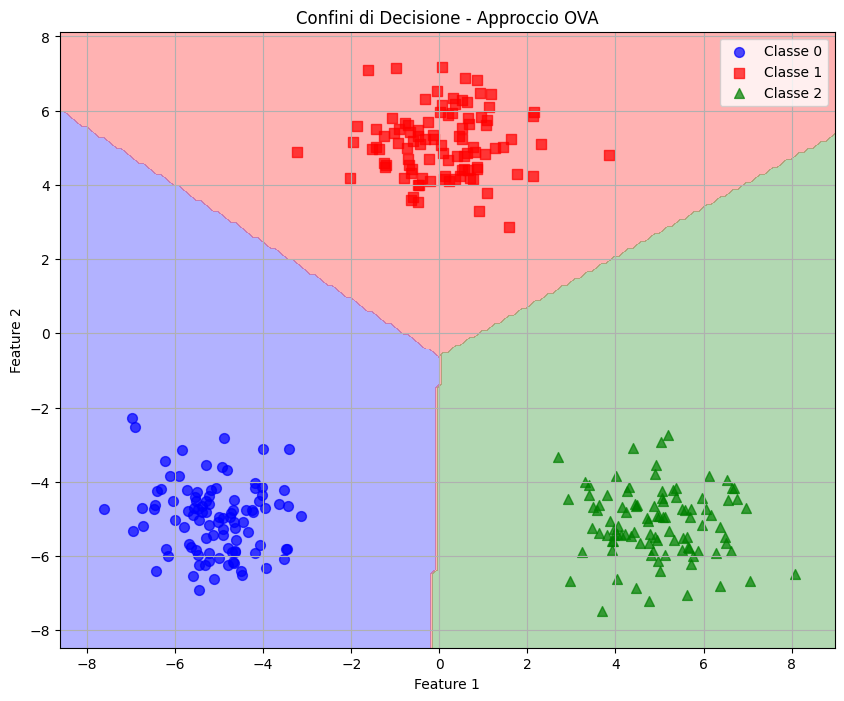

In [22]:
# Visualizziamo i confini di decisione del modello OVA
plot_decision_boundary(ova_model, X, y, 'Confini di Decisione - Approccio OVA')

## 4. Implementazione Regressione Logistica Multinomiale

Nell'approccio multinomiale (anche chiamato softmax), modelliamo direttamente le probabilità per tutte le classi usando la funzione softmax:

$$P(y=i|x) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$$

dove $z_i = w_i^T x$ è il punteggio non normalizzato per la classe $i$.

La funzione di costo usando la cross-entropy:

$$J(W) = -\frac{1}{N} \sum_{n=1}^{N} \sum_{j=1}^{K} t_{nj}\log \frac{e^{w_j^T x^{(n)}}}{\sum_{l=1}^{K} e^{w_l^T x^{(n)}}}$$

dove $t_{nj}$ vale 1 se l'esempio (ground truth) n appartiene alla classe j, altrimenti 0.


- La sommatoria interna riguarda la somma su tutte le K classi possibili
- La sommatoria esterna somma tutti gli esempi del dataset
Implementiamo ora la regressione logistica multinomiale:

#### Introduzione al One-Hot Encoding

La codifica One-Hot è una rappresentazione delle etichette di classe sotto forma di vettori binari. In questa rappresentazione:

1. Ogni esempio è rappresentato da un vettore di lunghezza $K$ (numero di classi)
2. Questo vettore contiene tutti zeri, tranne per un singolo uno nella posizione corrispondente alla classe dell'esempio

Ad esempio, in un problema con 3 classi (0, 1, 2), le etichette codificate diventerebbero:

- Classe 0 → [1, 0, 0]
- Classe 1 → [0, 1, 0]
- Classe 2 → [0, 0, 1]

Questo ci permette di separare i contributi di ciascuna classe nel calcolo della funzione di costo.

In [23]:
import numpy as np
# Esempio di dati
test_y = np.array([2, 0, 1, 2, 1, 0, 2, 1, 0, 1])  # Etichette originali
classes = np.array([0, 1, 2])                 # Classi uniche
n_samples = len(test_y)                            # Numero di esempi
n_classes = len(classes)                      # Numero di classi
# Creazione della matrice one-hot
y_one_hot = np.zeros((n_samples, n_classes))
# Ciclo per assegnare i valori one-hot
for i in range(n_samples):
    # Troviamo l'indice della classe corrente nell'array delle classi
    class_idx = np.where(classes == test_y[i])[0][0]
    # Impostiamo a 1 la posizione corrispondente alla classe
    y_one_hot[i, class_idx] = 1
# Stampiamo i risultati per confronto
print("Etichette originali:")
print(test_y)
print("\nEtichette codificate one-hot:")
print(y_one_hot)

Etichette originali:
[2 0 1 2 1 0 2 1 0 1]

Etichette codificate one-hot:
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [24]:
class MultinomialLogisticRegression:
    """
    Implementazione della regressione logistica multinomiale (softmax)
    """
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        """
        Inizializzazione del modello
        
        Parametri:
        learning_rate: tasso di apprendimento per la discesa del gradiente
        n_iterations: numero di iterazioni per la discesa del gradiente
        """
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.classes = None
        self.cost_history = []

    def _softmax(self, z):
        """
        Funzione softmax: converte punteggi in probabilità normalizzate
        
        La funzione softmax è definita come:
        softmax(z_i) = exp(z_i) / sum(exp(z_j)) per j=1...K
        
        Per evitare overflow, sottraiamo il valore massimo da ogni z
        """
        # Sottraiamo il massimo per stabilità numerica
        shift_z = z - np.max(z, axis=1, keepdims=True)
        exp_z = np.exp(shift_z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def fit(self, X, y):
        """
        Addestra il modello multinomiale
        
        Parametri:
        X -- matrice delle feature di shape (m, n)
        y -- vettore delle etichette di shape (m,)
        """
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_samples, n_features = X.shape
        
        # Aggiungiamo una colonna di 1 per il termine di bias
        X_bias = np.c_[np.ones((n_samples, 1)), X]
        n_features_bias = X_bias.shape[1]
        
        # Inizializziamo i pesi: una matrice di shape (n_features+1, n_classes)
        self.weights = np.zeros((n_features_bias, n_classes))
        
        # Convertiamo le etichette in formato one-hot
        y_one_hot = np.zeros((n_samples, n_classes))
        for i in range(n_samples):
            class_idx = np.where(self.classes == y[i])[0][0]
            y_one_hot[i, class_idx] = 1
        
        print("Avvio addestramento multinomiale...")
        
        for i in range(self.n_iterations):
            # Calcolo delle probabilità usando softmax
            scores = np.dot(X_bias, self.weights)  # shape: (m, K)
            probs = self._softmax(scores)  # shape: (m, K)
            
            # Calcolo del gradiente della cross-entropy
            # Formula: gradiente = (1/m) * X^T * (probs - y_one_hot)
            gradients = 1/n_samples * np.dot(X_bias.T, (probs - y_one_hot))
            
            # Aggiornamento dei pesi
            self.weights = self.weights - self.learning_rate * gradients
            
            # Calcolo e salvataggio del costo
            cost = self._compute_cost(X_bias, y_one_hot)
            self.cost_history.append(cost)
            
            # Stampa periodica del costo
            if (i % 100 == 0) or (i == self.n_iterations - 1):
                print(f"Iterazione {i}: Costo = {cost:.6f}")
        
        print("Addestramento multinomiale completato!")
        
        # Calcoliamo l'accuratezza sul training set
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        print(f"Accuratezza sul training set: {accuracy:.4f}")
    
    def _compute_cost(self, X, y_one_hot):
        """
        Calcola la funzione di costo (cross-entropy)
        
        J(W) = -(1/m) * sum(sum(y_ij * log(p_ij)))
        
        dove:
        y_ij = 1 se l'esempio i appartiene alla classe j, 0 altrimenti
        p_ij = probabilità predetta che l'esempio i appartenga alla classe j
        """
        m = X.shape[0]
        scores = np.dot(X, self.weights)
        probs = self._softmax(scores)
        
        # Aggiungiamo un valore piccolo per evitare log(0)
        epsilon = 1e-15
        probs = np.clip(probs, epsilon, 1 - epsilon)
        
        # Calcoliamo la cross-entropy: -sum(y_true * log(y_pred))
        log_probs = y_one_hot * np.log(probs)
        cost = -np.sum(log_probs) / m
        
        return cost
    
    def predict_proba(self, X):
        """
        Calcola le probabilità per tutte le classi
        
        Parametri:
        X -- matrice delle feature di shape (m, n)
        
        Restituisce:
        probs -- matrice di probabilità di shape (m, n_classes)
        """
        # Aggiungiamo una colonna di 1 per il termine di bias
        X_bias = np.c_[np.ones((X.shape[0], 1)), X]
        
        # Calcoliamo i punteggi e applichiamo softmax
        scores = np.dot(X_bias, self.weights)
        probs = self._softmax(scores)
        
        return probs
    
    def predict(self, X):
        """
        Predice la classe con la probabilità più alta
        
        Parametri:
        X -- matrice delle feature di shape (m, n)
        
        Restituisce:
        y_pred -- vettore delle classi predette di shape (m,)
        """
        probs = self.predict_proba(X)
        return self.classes[np.argmax(probs, axis=1)]
    
    def plot_cost_history(self):
        """
        Visualizza l'andamento della funzione di costo durante l'addestramento
        """
        plt.figure(figsize=(10, 6))
        plt.plot(range(self.n_iterations), self.cost_history)
        plt.xlabel('Iterazioni')
        plt.ylabel('Costo (Cross-Entropy)')
        plt.title('Andamento della funzione di costo')
        plt.grid(True)
        plt.show()

Avvio addestramento multinomiale...
Iterazione 0: Costo = 0.268337
Iterazione 100: Costo = 0.006125
Iterazione 200: Costo = 0.003293
Iterazione 300: Costo = 0.002284
Iterazione 400: Costo = 0.001760
Iterazione 500: Costo = 0.001438
Iterazione 600: Costo = 0.001218
Iterazione 700: Costo = 0.001059
Iterazione 800: Costo = 0.000937
Iterazione 900: Costo = 0.000842
Iterazione 999: Costo = 0.000766
Addestramento multinomiale completato!
Accuratezza sul training set: 1.0000


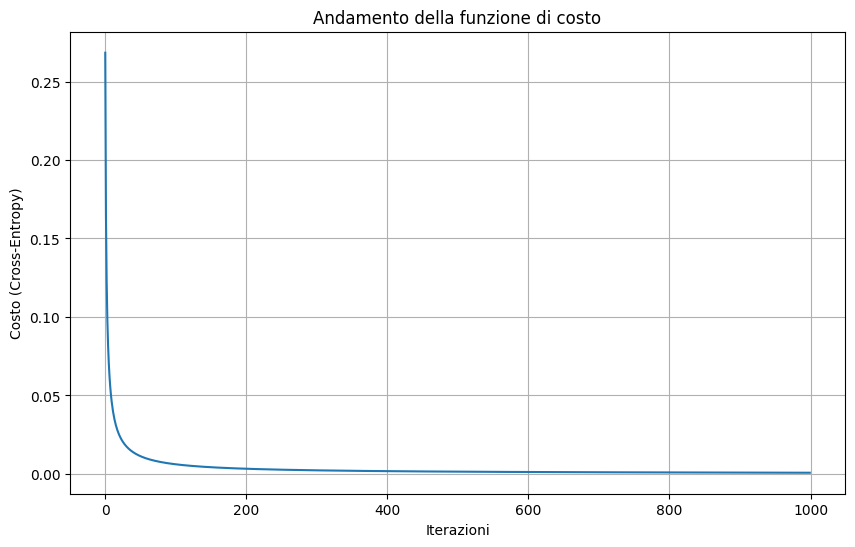

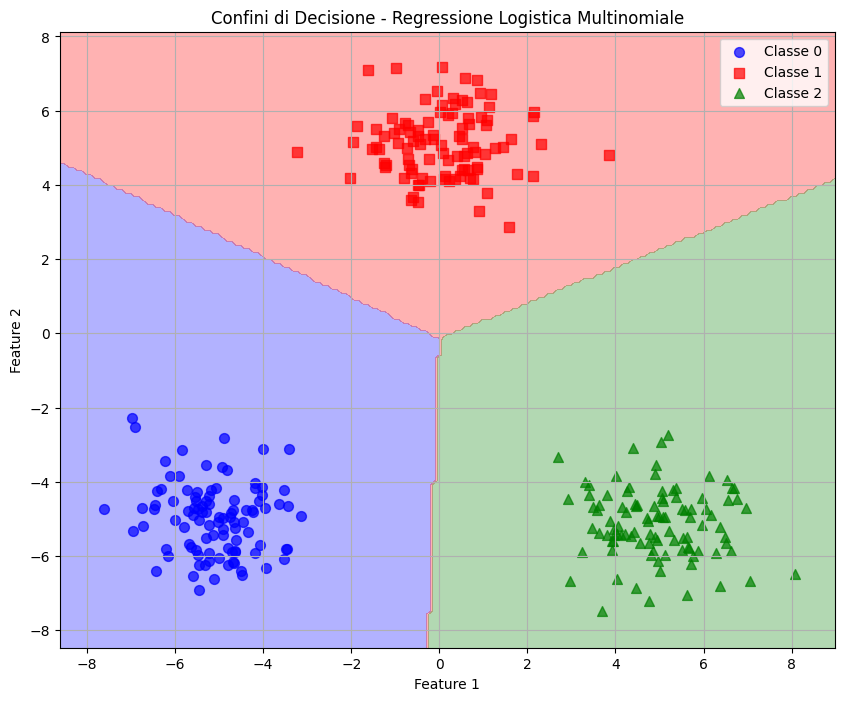

In [25]:
# Addestriamo il modello multinomiale
multinomial_model = MultinomialLogisticRegression(learning_rate=0.1, n_iterations=1000)
multinomial_model.fit(X, y)
# Visualizziamo l'andamento del costo
multinomial_model.plot_cost_history()
# Visualizziamo i confini di decisione
plot_decision_boundary(multinomial_model, X, y, 'Confini di Decisione - Regressione Logistica Multinomiale')

## 5. Confronto tra OVA e Approccio Multinomiale
Ora visualizziamo i confini di decisione di entrambi i modelli per confrontarli:

In [26]:
# Creiamo un dataset più complesso per il confronto
def create_complex_dataset(n_samples=400):
    """
    Creiamo un dataset più complesso con 4 classi in uno schema a spirale
    """
    np.random.seed(42)
    n_classes = 4
    n_samples_per_class = n_samples // n_classes
    
    X = np.zeros((n_samples, 2))
    y = np.zeros(n_samples, dtype=int)
    
    for i in range(n_classes):
        radius = np.linspace(0.0, 1, n_samples_per_class)
        theta = np.linspace(i * 4, (i + 1) * 4, n_samples_per_class) + np.random.randn(n_samples_per_class) * 0.2
        
        start_idx = i * n_samples_per_class
        end_idx = (i + 1) * n_samples_per_class
        
        X[start_idx:end_idx, 0] = radius * np.sin(theta)
        X[start_idx:end_idx, 1] = radius * np.cos(theta)
        y[start_idx:end_idx] = i
    
    # Mescoliamo i dati
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    
    return X, y

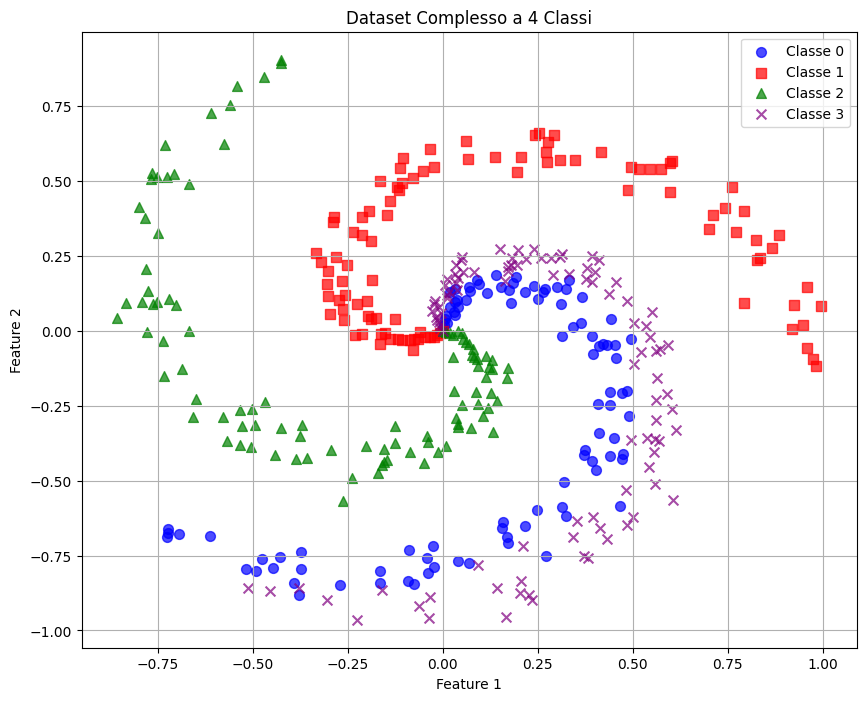

In [27]:
# Creiamo il dataset complesso
X_complex, y_complex = create_complex_dataset(n_samples=400)

# Visualizziamo il dataset
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'purple']
markers = ['o', 's', '^', 'x']

for i in range(4):
    plt.scatter(X_complex[y_complex == i, 0], X_complex[y_complex == i, 1], 
                color=colors[i], marker=markers[i], 
                s=50, alpha=0.7, label=f'Classe {i}')

plt.title('Dataset Complesso a 4 Classi')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

Addestramento di 4 classificatori OVA...

Classificatore per classe 0 vs resto:
  Iterazione 0: Costo = 0.686828
  Iterazione 200: Costo = 0.527909
  Iterazione 400: Costo = 0.515404
  Iterazione 600: Costo = 0.511113
  Iterazione 800: Costo = 0.509498
  Iterazione 999: Costo = 0.508853
Accuratezza per classe 0: 0.7125

Classificatore per classe 1 vs resto:
  Iterazione 0: Costo = 0.685948
  Iterazione 200: Costo = 0.471597
  Iterazione 400: Costo = 0.440433
  Iterazione 600: Costo = 0.426500
  Iterazione 800: Costo = 0.419303
  Iterazione 999: Costo = 0.415257
Accuratezza per classe 1: 0.8425

Classificatore per classe 2 vs resto:
  Iterazione 0: Costo = 0.685967
  Iterazione 200: Costo = 0.473096
  Iterazione 400: Costo = 0.443950
  Iterazione 600: Costo = 0.432262
  Iterazione 800: Costo = 0.426957
  Iterazione 999: Costo = 0.424356
Accuratezza per classe 2: 0.8300

Classificatore per classe 3 vs resto:
  Iterazione 0: Costo = 0.686840
  Iterazione 200: Costo = 0.527672
  Iterazione

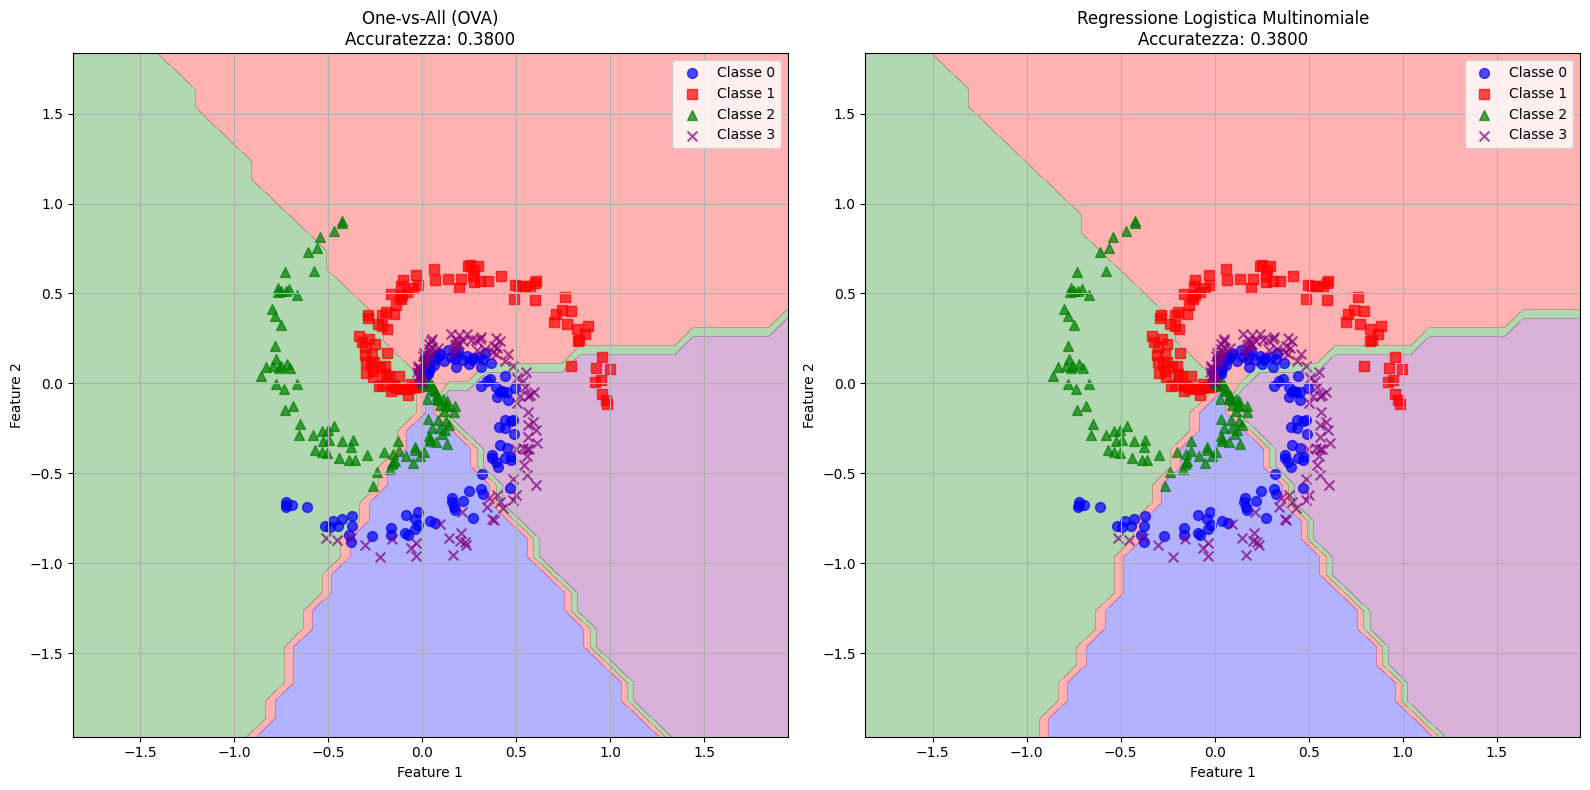

In [28]:
# Calcoliamo e confrontiamo l'accuratezza
ova_complex = LogisticRegressionOVA(learning_rate=0.1, n_iterations=1000)
ova_complex.fit(X_complex, y_complex)

y_pred_ova = ova_complex.predict(X_complex)
ova_accuracy = np.mean(y_pred_ova == y_complex)


multinomial_complex = MultinomialLogisticRegression(learning_rate=0.1, n_iterations=1000)
multinomial_complex.fit(X_complex, y_complex) 

y_pred_multi = multinomial_complex.predict(X_complex)
multi_accuracy = np.mean(y_pred_multi == y_complex)

print("\nConfronto di accuratezza sul dataset complesso:")
print(f"One-vs-All (OVA): {ova_accuracy:.4f}")
print(f"Regressione Logistica Multinomiale: {multi_accuracy:.4f}")

# Possiamo anche includere l'accuratezza nei titoli dei grafici
plt.figure(figsize=(16, 8))

# Visualizziamo OVA con accuratezza
plt.subplot(1, 2, 1)
plot_decision_boundary(ova_complex, X_complex, y_complex, 
                     f'One-vs-All (OVA)\nAccuratezza: {ova_accuracy:.4f}', 
                     subplot=plt, resolution=0.1)

# Visualizziamo multinomiale con accuratezza
plt.subplot(1, 2, 2)
plot_decision_boundary(multinomial_complex, X_complex, y_complex, 
                     f'Regressione Logistica Multinomiale\nAccuratezza: {multi_accuracy:.4f}', 
                     subplot=plt, resolution=0.1)

plt.tight_layout() 
plt.show()


Matrice di Confusione - One-vs-All:


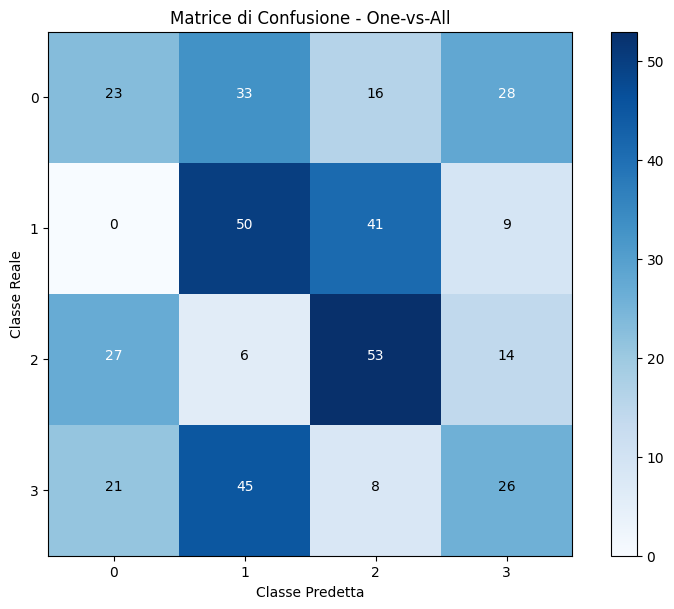


Matrice di Confusione - Regressione Logistica Multinomiale:


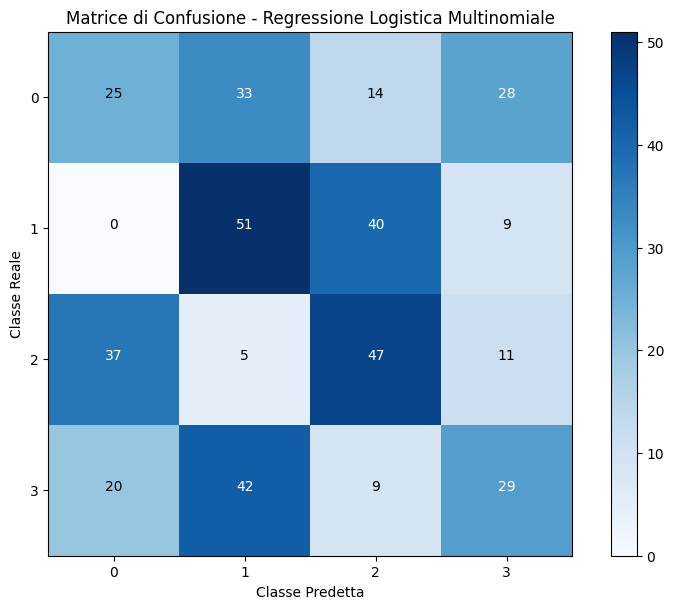

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes, title):
    """
    Visualizza la matrice di confusione
    """
    cm = np.zeros((len(classes), len(classes)), dtype=int)
    for i in range(len(y_true)):
        cm[y_true[i], y_pred[i]] += 1
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    
    # Etichette
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Valori nella matrice
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('Classe Reale')
    plt.xlabel('Classe Predetta')
    plt.show()

# Utilizziamo la funzione per entrambi i modelli
print("\nMatrice di Confusione - One-vs-All:")
plot_confusion_matrix(y_complex, y_pred_ova, np.unique(y_complex), 
                      'Matrice di Confusione - One-vs-All')

print("\nMatrice di Confusione - Regressione Logistica Multinomiale:")
plot_confusion_matrix(y_complex, y_pred_multi, np.unique(y_complex), 
                      'Matrice di Confusione - Regressione Logistica Multinomiale')

## 7. Confronto tra OVA e Multinomiale:

| Caratteristica | One-vs-All (OVA) | Regressione Logistica Multinomiale |
|----------------|------------------|-----------------------------------|
| **Principio** | Addestra K classificatori binari | Addestra un singolo modello multiclasse |
| **Funzione** | Sigmoide | Softmax |
| **Parametri** | K modelli con n+1 parametri ciascuno | 1 modello con K×(n+1) parametri |
| **Confini di decisione** | Lineari, possono intersecarsi | Lineari |

### Vantaggi e Svantaggi

**One-vs-All (OVA)**:
- Più semplice da implementare
- Facilmente parallelizzabile (ogni classificatore può essere addestrato separatamente)
- Funziona bene quando le classi sono ben separate
- Può creare regioni di decisione ambigue (dove più classificatori danno 1 o tutti danno 0)
- Non considera le relazioni tra classi

**Regressione Logistica Multinomiale**:
- Modella direttamente le probabilità per tutte le classi
- Produce confini di decisione più coerenti
- Spesso più accurata per classi non linearmente separabili
- Più complessa da implementare
- Più costosa computazionalmente

## 8. Conclusioni

In questo notebook abbiamo implementato e confrontato due approcci per la classificazione multiclasse:

1. **One-vs-All (OVA)**: Addestriamo un classificatore binario separato per ogni classe
2. **Regressione Logistica Multinomiale**: Addestriamo un unico modello che predice direttamente le probabilità per tutte le classi

Entrambi gli approcci hanno i loro punti di forza e di debolezza. La scelta tra i due dipende dal caso d'uso specifico e dalle caratteristiche del dataset.

Ricordiamo che i confini di decisione della regressione logistica sono sempre lineari. Per problemi più complessi, potremmo aver bisogno di:
- Aggiungere termini polinomiali alle feature
- Utilizzare kernel per mappare i dati in uno spazio di dimensione superiore
- Considerare altri algoritmi come SVM, alberi decisionali o reti neurali

## Appendice: Notazione Matematica

### One-vs-All (OVA)

Per ogni classe $k$, addestriamo un classificatore binario:

$$P(y=k|x) = \sigma(w_k^T x) = \frac{1}{1 + e^{-w_k^T x}}$$

La funzione di costo per ogni classificatore è:

$$J(w_k) = -\frac{1}{m} \sum_{i=1}^{m} [y_k^{(i)} \log(\sigma(w_k^T x^{(i)})) + (1-y_k^{(i)}) \log(1-\sigma(w_k^T x^{(i)}))]$$

dove $y_k^{(i)} = 1$ se $y^{(i)} = k$, altrimenti $y_k^{(i)} = 0$.

Il gradiente per ogni classificatore è:

$$\nabla J(w_k) = \frac{1}{m} \sum_{i=1}^{m} (\sigma(w_k^T x^{(i)}) - y_k^{(i)}) x^{(i)}$$

### Regressione Logistica Multinomiale

La funzione softmax per calcolare le probabilità di tutte le classi:

$$P(y=k|x) = \frac{e^{w_k^T x}}{\sum_{j=1}^{K} e^{w_j^T x}}$$

La funzione di costo (cross-entropy):

$$J(W) = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_k^{(i)} \log(P(y=k|x^{(i)}))$$

dove $y_k^{(i)} = 1$ se $y^{(i)} = k$, altrimenti $y_k^{(i)} = 0$.

Il gradiente rispetto ai pesi $w_k$:

$$\nabla_{w_k} J(W) = \frac{1}{m} \sum_{i=1}^{m} (P(y=k|x^{(i)}) - y_k^{(i)}) x^{(i)}$$